In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t


In [ ]:
# Step 2: Load and prepare the data
qvi_data = pd.read_csv('/content/QVI_data.csv')
qvi_data['DATE'] = pd.to_datetime(qvi_data['DATE'])
qvi_data['YEARMONTH'] = qvi_data['DATE'].dt.to_period('M').astype(str).str.replace('-', '').astype(int)

print(qvi_data.info())
print(qvi_data.describe())
qvi_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264834 non-null  int64         
 1   DATE              264834 non-null  datetime64[ns]
 2   STORE_NBR         264834 non-null  int64         
 3   TXN_ID            264834 non-null  int64         
 4   PROD_NBR          264834 non-null  int64         
 5   PROD_NAME         264834 non-null  object        
 6   PROD_QTY          264834 non-null  int64         
 7   TOT_SALES         264834 non-null  float64       
 8   PACK_SIZE         264834 non-null  int64         
 9   BRAND             264834 non-null  object        
 10  LIFESTAGE         264834 non-null  object        
 11  PREMIUM_CUSTOMER  264834 non-null  object        
 12  YEARMONTH         264834 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7), object(4)
memor

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811


In [ ]:
# Step 3: Create monthly metrics
monthly_metrics = qvi_data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', pd.Series.nunique),
    nTransactions=('TXN_ID', pd.Series.nunique),
    nChips=('PROD_QTY', 'sum')
).reset_index()

In [ ]:
# Step 4: Add derived metrics
monthly_metrics['nTxnPerCust'] = monthly_metrics['nTransactions'] / monthly_metrics['nCustomers']
monthly_metrics['nChipsPerTxn'] = monthly_metrics['nChips'] / monthly_metrics['nTransactions']
monthly_metrics['avgPricePerUnit'] = monthly_metrics['totSales'] / monthly_metrics['nChips']


In [ ]:
# Step 5: Define correlation function
def calculate_correlation(metric_df, store_trial, metric='totSales'):
    trial = metric_df[metric_df['STORE_NBR'] == store_trial].sort_values('YEARMONTH')
    correlations = []
    for store in metric_df['STORE_NBR'].unique():
        if store == store_trial:
            continue
        control = metric_df[metric_df['STORE_NBR'] == store].sort_values('YEARMONTH')
        merged = pd.merge(trial, control, on='YEARMONTH', suffixes=('_trial', '_ctrl'))
        if merged.empty or len(merged) < 6:
            continue
        corr = merged[f'{metric}_trial'].corr(merged[f'{metric}_ctrl'])
        correlations.append((store_trial, store, corr))
    return pd.DataFrame(correlations, columns=['Store1', 'Store2', 'corr_measure'])


In [ ]:
# Step 6: Define magnitude distance function
def calculate_magnitude(metric_df, store_trial, metric='totSales'):
    trial = metric_df[metric_df['STORE_NBR'] == store_trial]
    distances = []
    for store in metric_df['STORE_NBR'].unique():
        if store == store_trial:
            continue
        control = metric_df[metric_df['STORE_NBR'] == store]
        merged = pd.merge(trial, control, on='YEARMONTH', suffixes=('_trial', '_ctrl'))
        if merged.empty or len(merged) < 6:
            continue
        dist = abs(merged[f'{metric}_trial'] - merged[f'{metric}_ctrl'])
        norm_score = 1 - (dist - dist.min()) / (dist.max() - dist.min() + 1e-9)
        distances.append((store_trial, store, norm_score.mean()))
    return pd.DataFrame(distances, columns=['Store1', 'Store2', 'mag_measure'])

In [ ]:
# Step 7: Define control store selector function
def find_best_control_store(trial_store, metric_df, metric='totSales'):
    pretrial_df = metric_df[metric_df['YEARMONTH'] < 201902]
    corr_df = calculate_correlation(pretrial_df, trial_store, metric=metric)
    mag_df = calculate_magnitude(pretrial_df, trial_store, metric=metric)
    if corr_df.empty or mag_df.empty:
        return None
    control_score = pd.merge(corr_df, mag_df, on=['Store1', 'Store2'])
    control_score['final_score'] = 0.5 * control_score['corr_measure'] + 0.5 * control_score['mag_measure']
    control_score = control_score.sort_values(by='final_score', ascending=False)
    return control_score.iloc[0]['Store2'], control_score


In [ ]:
# Step 8: Apply function to all trial stores
trial_stores = [77, 86, 88]
control_store_results = {}
for trial in trial_stores:
    control_store, full_table = find_best_control_store(trial, monthly_metrics)
    control_store_results[trial] = {
        'control_store': control_store,
        'comparison_table': full_table
    }

for trial, result in control_store_results.items():
    print(f"Trial store {trial} → Best control store: {int(result['control_store'])}")

Trial store 77 → Best control store: 71
Trial store 86 → Best control store: 155
Trial store 88 → Best control store: 134


In [ ]:
# Function to scale control and plot trial vs control store
def plot_metric_comparison(trial_store, control_store, metric, title=None):
    subset = monthly_metrics[
        (monthly_metrics['STORE_NBR'].isin([trial_store, control_store])) &
        (monthly_metrics['YEARMONTH'] < 201905)
    ].copy()

    # Tag store type
    subset['Store_Type'] = subset['STORE_NBR'].apply(lambda x: 'Trial' if x == trial_store else 'Control')

    # Scale control store to match pre-trial levels
    pre_trial = subset['YEARMONTH'] < 201902
    pre_totals = subset[pre_trial].groupby('Store_Type')[metric].sum()
    scaling_factor = pre_totals['Trial'] / pre_totals['Control']
    subset['scaled_metric'] = subset.apply(
        lambda row: row[metric] * scaling_factor if row['Store_Type'] == 'Control' else row[metric],
        axis=1
    )

    # Plot
    plt.figure(figsize=(12, 5))
    for store_type in ['Trial', 'Control']:
        data = subset[subset['Store_Type'] == store_type]
        plt.plot(data['YEARMONTH'], data['scaled_metric'], marker='o', label=f"{store_type} Store")

    # Highlight trial period
    plt.axvspan(201902, 201904, color='gray', alpha=0.2, label='Trial Period')
    plt.title(title or f"{metric} Comparison – Trial {trial_store} vs Control {control_store}")
    plt.xlabel("Year-Month")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



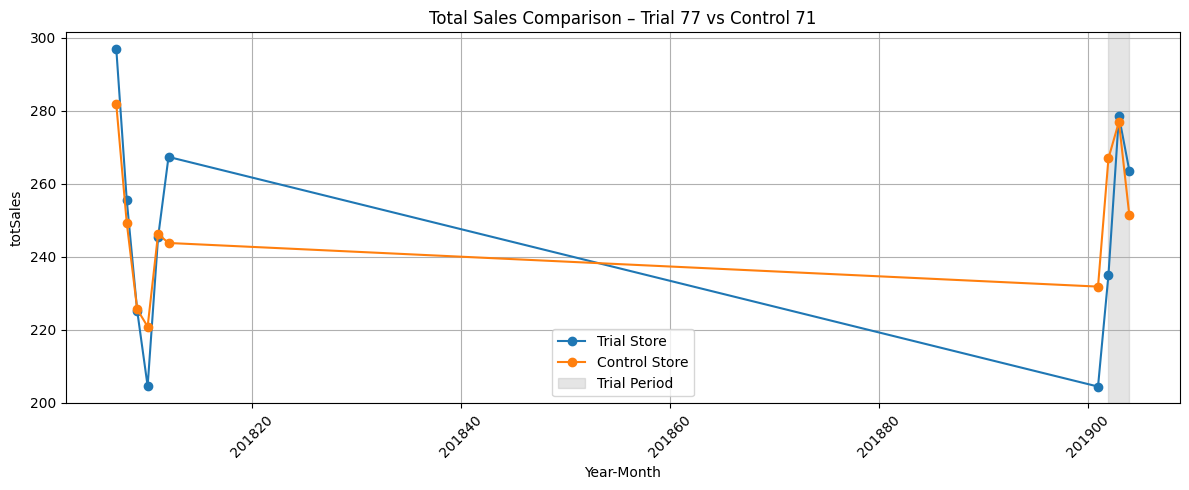

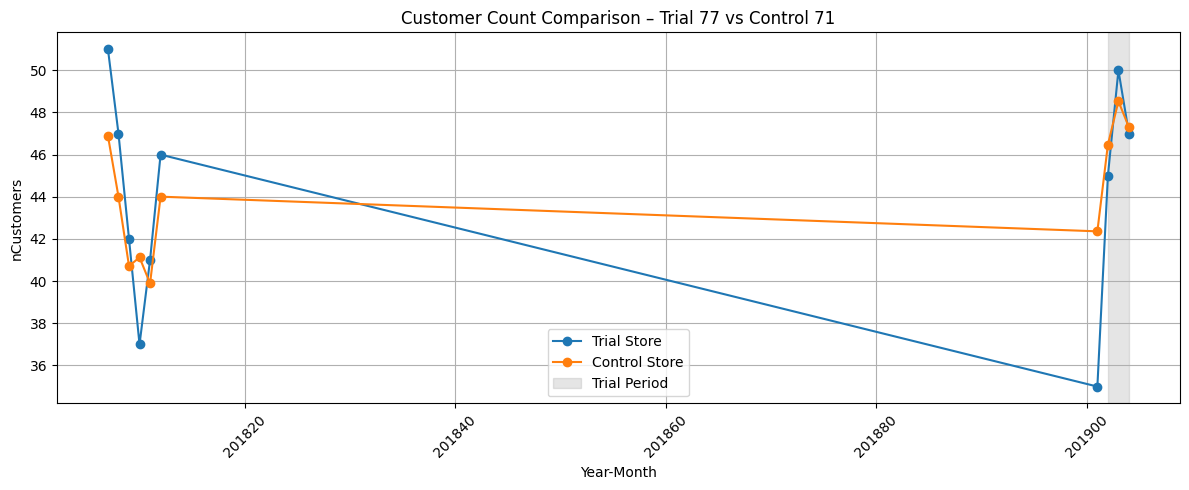

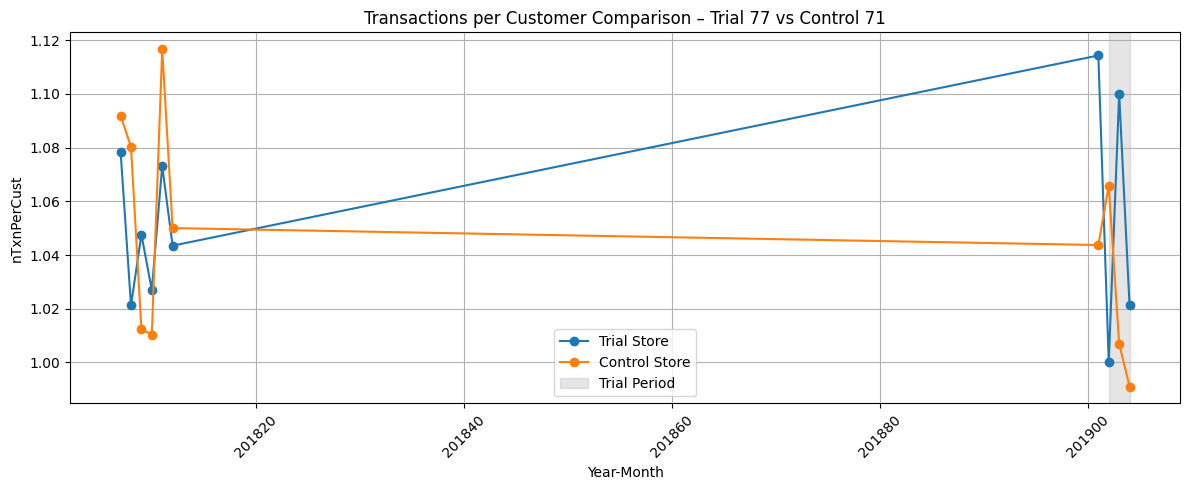

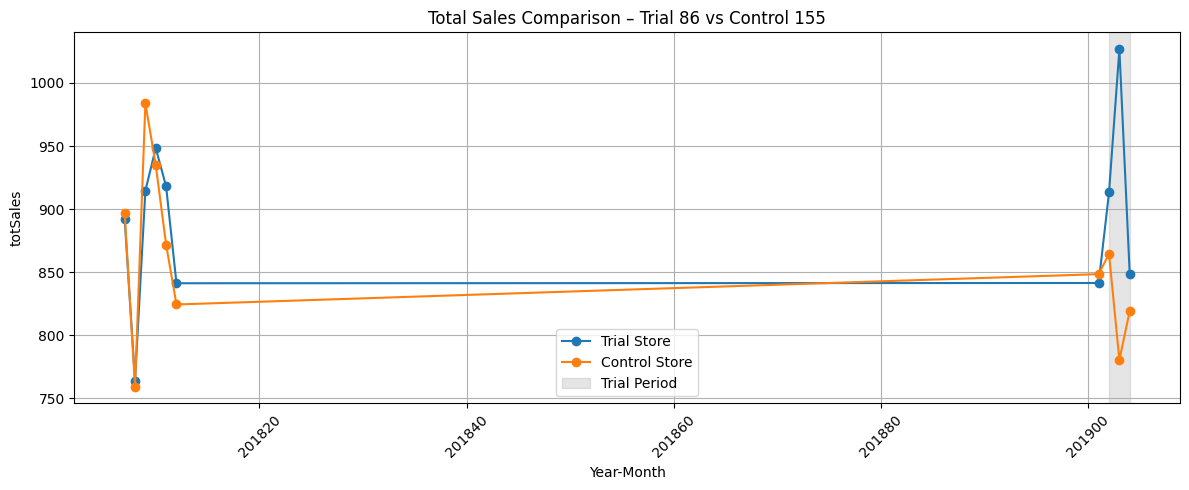

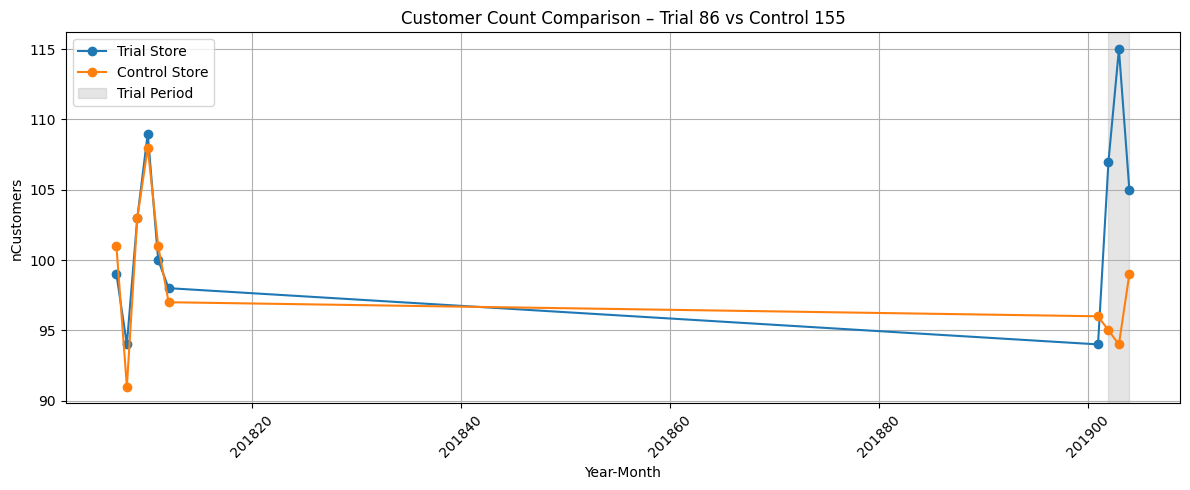

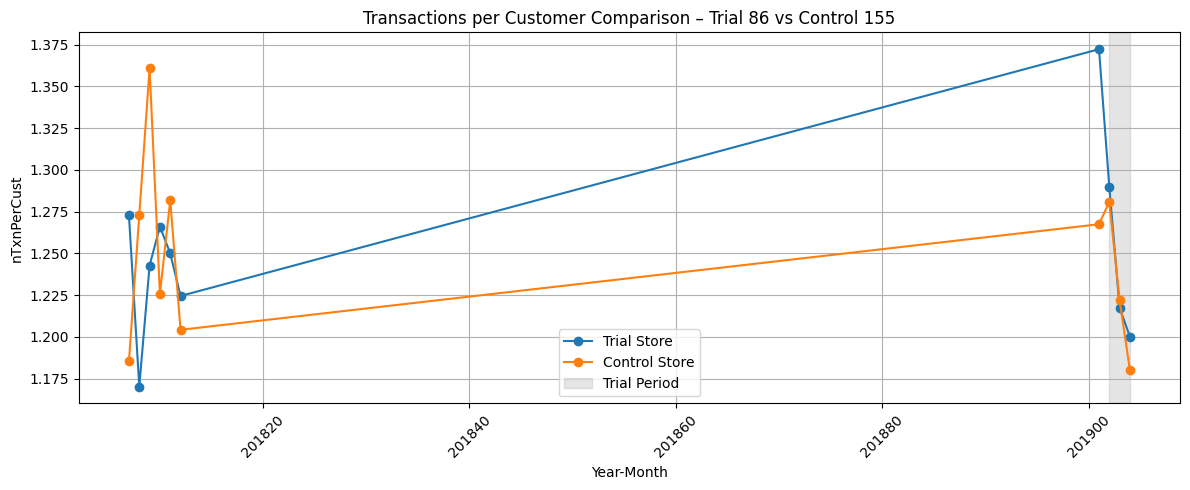

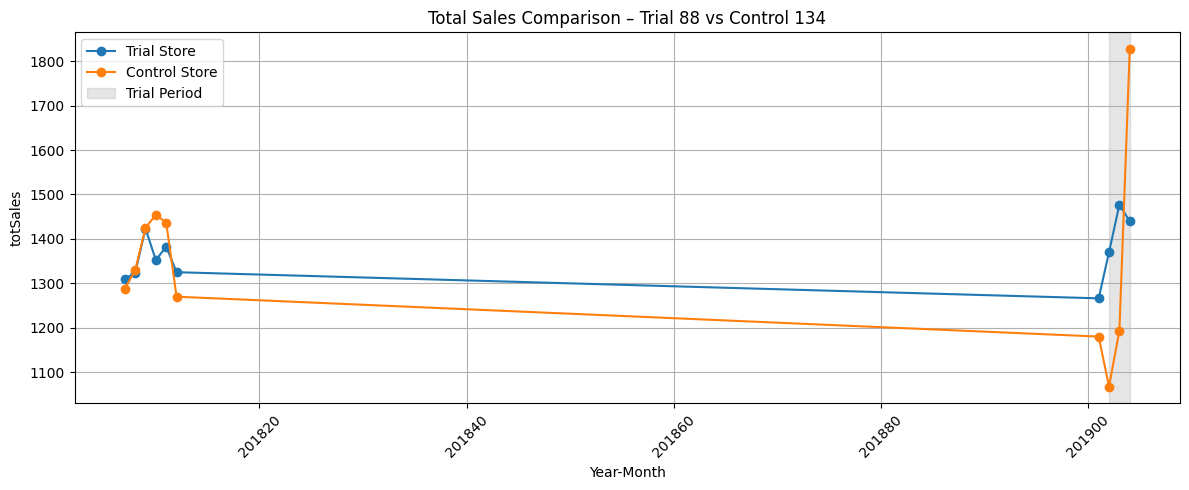

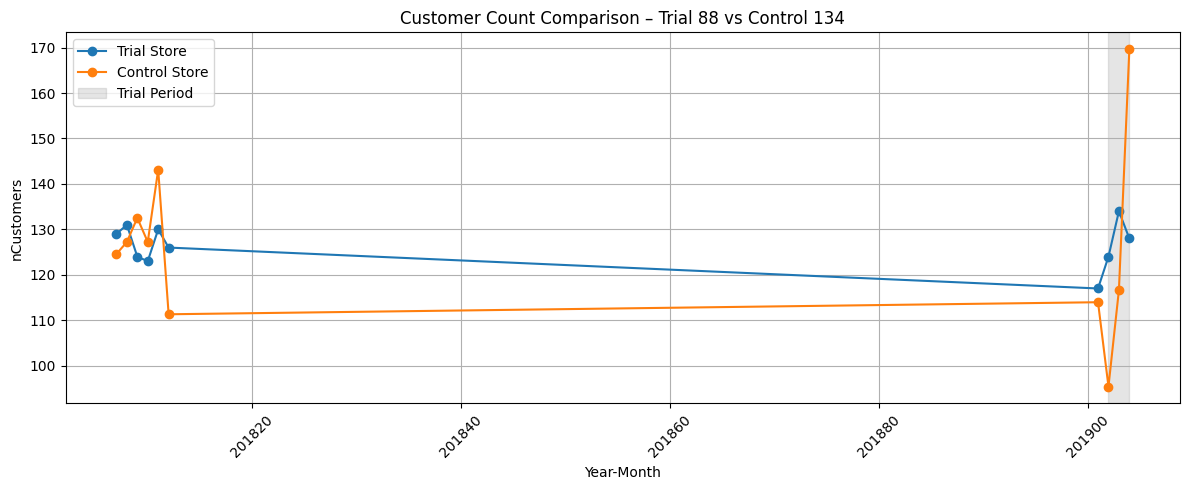

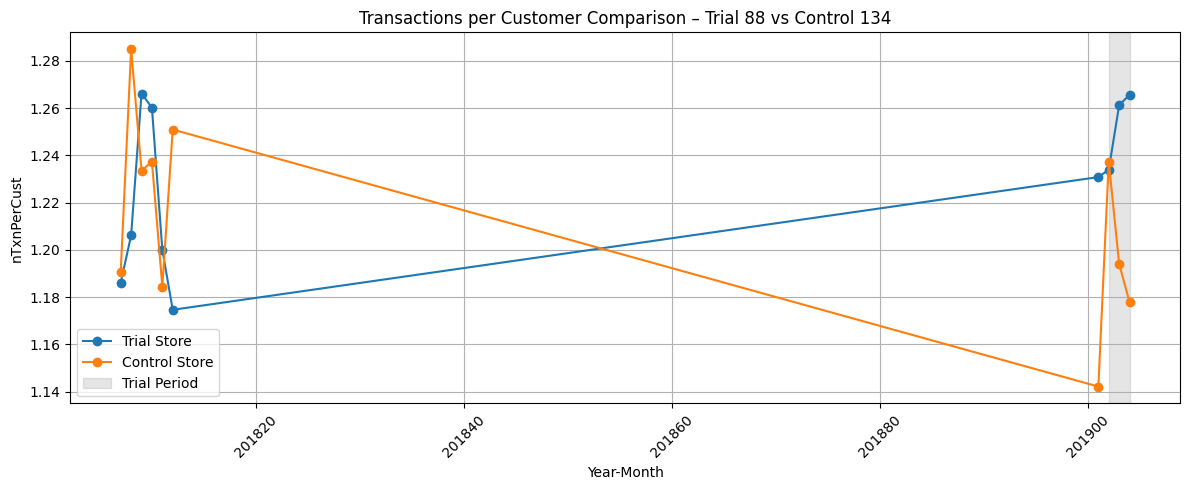

In [ ]:
# Define the metrics you want to visualize
metrics_to_plot = ['totSales', 'nCustomers', 'nTxnPerCust']
metric_titles = {
    'totSales': 'Total Sales Comparison',
    'nCustomers': 'Customer Count Comparison',
    'nTxnPerCust': 'Transactions per Customer Comparison'
}

# Loop through all trial stores and their matched control stores
for trial in trial_stores:
    control = int(control_store_results[trial]['control_store'])
    for metric in metrics_to_plot:
        plot_metric_comparison(
            trial_store=trial,
            control_store=control,
            metric=metric,
            title=f'{metric_titles[metric]} – Trial {trial} vs Control {control}'
        )
